In [1]:
%matplotlib inline

In [2]:
!pip install ipython
!pip install -q livelossplot==0.3.3
!pip install -q ipython-autotime
%load_ext autotime

time: 409 µs (started: 2022-07-29 08:46:03 +00:00)


In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import csv
import os
import tarfile
from urllib.parse import urlparse
from urllib.request import urlretrieve
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
cudnn.benchmark = True
plt.ion()   # interactive mode

time: 2.8 s (started: 2022-07-29 08:46:03 +00:00)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0
time: 60.2 ms (started: 2022-07-29 08:46:06 +00:00)


In [5]:
%%bash
pwd
unzip "../input/isic-ds/ISIC_2019_Training_Input.zip"

/kaggle/working
Archive:  ../input/isic-ds/ISIC_2019_Training_Input.zip
   creating: ISIC_2019_Training_Input/
  inflating: ISIC_2019_Training_Input/ATTRIBUTION.txt  
  inflating: ISIC_2019_Training_Input/ISIC_0000000.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000001.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000002.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000003.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000004.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000006.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000007.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000008.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000009.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000010.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000011.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000012.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000013.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0000014.jpg  
  inflating: ISIC_2019_Training_Inp

In [6]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()

time: 1.95 ms (started: 2022-07-29 08:48:31 +00:00)


In [7]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('../input/isic-ds/ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = 'ISIC_2019_Training_Input/'+X_train['image']+ '.jpg'
X_test['image'] = 'ISIC_2019_Training_Input/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
test_meta = 'ISIC_2019_Test_Metadata.csv'
train_img_path = 'ISIC_2019_Training_Input'

time: 1.02 s (started: 2022-07-29 08:48:31 +00:00)


In [8]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 1.95 ms (started: 2022-07-29 08:48:32 +00:00)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True)
image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,shuffle=True, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 373 ms (started: 2022-07-29 08:48:32 +00:00)


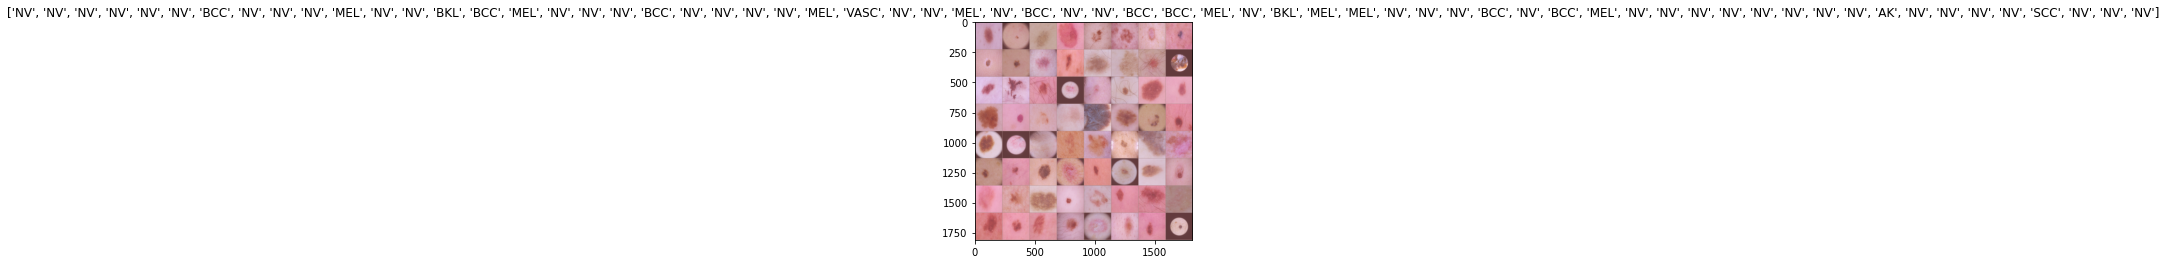

time: 5.9 s (started: 2022-07-29 08:48:33 +00:00)


In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [11]:
model=models.resnet18(pretrained=False)
model.fc=nn.Sequential(nn.Linear(512, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isicasl/ASLRESNET18_wt_epoch_11_batch_312_auc_0.8514.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

time: 5.03 s (started: 2022-07-29 08:48:40 +00:00)


In [12]:
def validate():
    model.eval()
    
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        #labels = labels.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()#.cpu().numpy()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images
             
    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)

        
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)
            
    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    print('\n')
    print(auc_lst)
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print(auc)
    print(acc)
    f1s=0.0
    model.train()
    return auc,acc,f1s

time: 1.66 ms (started: 2022-07-29 08:48:45 +00:00)


In [13]:
def update_lr(optimizer,lr):
    for param in optimizer.param_groups:
        param["lr"]=lr
    
    return optimizer

time: 474 µs (started: 2022-07-29 08:48:45 +00:00)


In [14]:
validate()



[0.8398067  0.90536856 0.93554155 0.91877906 0.84357079 0.78731309
 0.70144832 0.87928144]


[0.82706767 0.81898496 0.89718045 0.96033835 0.89304511 0.9906015
 0.99003759 0.9712406 ]
0.8513886901226422
0.918562030075188


(0.8513886901226422, 0.918562030075188, 0.0)

time: 1min 44s (started: 2022-07-29 08:48:45 +00:00)


In [15]:
def train_end_to_end(mx_lr):

    criterion= AsymmetricLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=mx_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
    
    total_batches=len(dataloaders['train'])
    cycle_length= len(dataloaders['train'])*2
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cycle_length, eta_min=0, last_epoch=-1)
    model.train()
    running_loss=0
    count=0
    max_epochs=2
    for epoch in range(0, max_epochs):
        
        for i, sample in enumerate(dataloaders['train']):
    
            images=sample['image'].float()
            labels=sample['target'].float()
            del sample
            images = images.to(device)
            labels = labels.to(device)
            outputs=model(images)
            loss = criterion(outputs, labels)
            running_loss=running_loss+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if (i+1) % 25 == 0: # displays after every 20 batches
                    print ("Epoch [{}/{}], Batch [{}/{}] Classification Loss: {:.4f}"
                       .format(epoch+1, max_epochs, i+1, total_batches, 
                        running_loss/(i+1) ), end ="\r")
                    
            count=count+1
            if count>=cycle_length:
                count=0
                auc,acc,f1=validate()
                # Save the weight
                auc=np.round(auc,4)
                nm='ASLRESNET18_wt_epoch_'+str(epoch)+'_batch_'+str(i)+'_auc_'+str(auc)+'.pt'
                torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, nm)
                del nm
                running_loss=0
                optimizer=update_lr(optimizer, mx_lr)
                scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cycle_length, eta_min=0, last_epoch=-1)
    
    return model

time: 2.67 ms (started: 2022-07-29 08:50:30 +00:00)


In [16]:
model=train_end_to_end( mx_lr=10**(-4))

Epoch [2/2], Batch [300/313] Classification Loss: 48.3548

[0.83686776 0.90413575 0.93213285 0.92182467 0.8416387  0.7495408
 0.65523319 0.87276874]


[0.82838346 0.81804511 0.89793233 0.96184211 0.89379699 0.9906015
 0.99003759 0.97180451]
0.8392678078267093
0.9190554511278195
time: 15min 2s (started: 2022-07-29 08:50:30 +00:00)
